<a href="https://colab.research.google.com/github/gacerioni/redisvl_gabs_facial_recognition/blob/main/redisvl_facial_recognition_recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)

# Facial Recognition from scratch with the Redis Vector Library

In this recipe, we will cover the basics of facial recognition using the **DeepFace** library with the `Facenet` model for embedding generation. Redis Vector Library (RedisVL) will be used to transform Redis into a high-performance vector database, enabling efficient similarity searches for facial recognition.

This demonstration showcases how to build a scalable and efficient facial recognition system by combining a pre-trained open-source model with the flexibility and power of Redis.

### Why RedisVL?

**RedisVL** provides native support for vector similarity search and indexing, making it easy to manage, query, and scale vectorized data. By using RedisVL, we simplify the implementation of vector search functionality that is critical for facial recognition systems.

### Redis Cloud

This is one of the many demos that can run seamlessly on a [Redis Cloud](https://redis.io/try-free/) database. Redis Cloud ensures high availability, low latency, and scalability for production-ready applications.

## Let's Begin!
<a href="https://colab.research.google.com/drive/10NIL5yv81XzKPEe4dwP5RMWSOWnq2x3d?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Environment Setup

### Install a local Redis Stack - or Redis 8
Because you are likely running this notebook in **Google Colab**, we need to first setup Redis right here.

**If you are running this notebook locally**, FYI you may not need to perform this step at all.

**Then, with the Redis running, you may opt to do one of these:**


*   We restore a `.rdb` file that has around 250 celebrities faces;
*   or we simply let the program ingest every celeb from a dataset I keep in a S3 Bucket.

The ingestion consist in generating a Redis HASH with the **Celebrity Name**, their Facial Features **embedding**, and one good **facial picture converted to its binary version**.\
*Naturally, in Production, you can keep the original images and objects in a Object Store. I am keeping the image JPEG as a binary in Redis just for educational purposes.*

**This is one of the Redis HASHes produced by this Lab:**


![RedisVL_HASH_EXAMPLE](https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/redisvl_hash_example.png)


#### Let's start by creating your local Redis instance then:



In [ ]:
# Install Redis and dependencies
!sudo apt-get install lsb-release curl gpg
!curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
!sudo chmod 644 /usr/share/keyrings/redis-archive-keyring.gpg
!echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
!sudo apt-get update
!sudo apt-get install redis-stack-server

# Start Redis in the background
!redis-stack-server --daemonize yes

# Verify Redis is running
!redis-cli ping

# Check Redis modules
!redis-cli INFO | grep -A 10 -i "modules"

# Verify Redis data directory
!redis-cli CONFIG GET dir

# COMMENT OUT FROM THIS LINE TO THE END IF YOU WANT THE PROGRAM TO GENERATE THE HASHES FROM SCRATCH
# Download the RDB snapshot
!wget -O /content/dump.rdb https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/dump.rdb

# Stop Redis to replace dump.rdb
!redis-cli shutdown save

# Move the downloaded RDB file
!sudo mv /content/dump.rdb /var/lib/redis-stack/dump.rdb
!sudo chmod 644 /var/lib/redis-stack/dump.rdb

# Restart Redis
!redis-stack-server --daemonize yes

# Wait for Redis to finish loading
import time
time.sleep(10)  # Adjust time as needed based on RDB size

# Verify the data
!redis-cli ping
!redis-cli dbsize

# List some keys
!redis-cli keys '*'

### Install Python Dependencies

In [ ]:
# Install Python dependencies
!pip install numpy pillow redis redisvl requests deepface -q

# Required imports
import os
import requests
import base64
import numpy as np
from PIL import Image, UnidentifiedImageError
from redisvl.index import SearchIndex
from redis import Redis
from urllib.parse import urlparse
from deepface import DeepFace
import matplotlib.pyplot as plt
from io import BytesIO
from zipfile import ZipFile

### Define Global variables

Let's set up some important variables. Feel free to use your own Redis, including **Redis Cloud**.\
This step will also download the original Celeb dataset we keep in an S3 Bucket.

In [ ]:
# Global variables
REDIS_URL = "redis://localhost:6379"
SAFE_THRESHOLD = 0.46
DATASET_URL = "https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/kaggle_famous_people_dataset.zip"
DATASET_PATH = "kaggle_famous_people_dataset"

# Download and extract dataset
if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    response = requests.get(DATASET_URL)
    with open("dataset.zip", "wb") as f:
        f.write(response.content)
    print("Extracting dataset...")
    with ZipFile("dataset.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove("dataset.zip")
    print("Dataset ready.")

#### For Alternative Environments
There are many ways to get the necessary redis-stack instance running
1. On cloud, deploy a [FREE instance of Redis in the cloud](https://redis.com/try-free/). Or, if you have your
own version of Redis Enterprise running, that works too!
2. Per OS, [see the docs](https://redis.io/docs/latest/operate/oss_and_stack/install/install-stack/)
3. With docker: `docker run -d --name redis-stack-server -p 6379:6379 redis/redis-stack-server:latest`

## Program Functions

Here we will define some functions that will help us deal with Redis as a Vector Database.

We will be using **RedisVL**, so we'll leverage existing OOTB features from the Redis API, such as our **Query Engine**. Everything that you will see here is native, supported.

### Helper Functions
These are functions that will help us connect to Redis, housekeep it, and help us process images from URLs. They are not the core of the app, but are important.

In [ ]:
def get_redis_connection(redis_url):
    """Create a Redis connection from a URL."""
    parsed_url = urlparse(redis_url)
    return Redis(
        host=parsed_url.hostname,
        port=parsed_url.port or 6379,
        password=parsed_url.password,
        decode_responses=False  # Binary storage enabled
    )

def load_remote_image(url):
    """Download and return an image from a URL."""
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content))

def generate_embedding(image_path):
    """Generate an embedding for the image."""
    try:
        embedding = DeepFace.represent(image_path, model_name="Facenet")
        return np.array(embedding[0]["embedding"], dtype=np.float32)
    except Exception as e:
        print(f"Error generating embedding for {image_path}: {e}")
        return None

def display_images_side_by_side(images, titles, figsize=(8, 4)):
    """Display a list of images side by side."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        img = img.convert("RGB")  # Convert images to RGB
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

def clear_face_docs(client):
    """Delete all face_docs:* entries in Redis."""
    keys = client.keys("face_docs:*")
    if keys:
        client.delete(*keys)
        print(f"Deleted {len(keys)} keys matching 'face_docs:*'.")
    else:
        print("No keys matching 'face_docs:*' found.")

### Core Functions

These functions define the main functionality of the demo, focusing on leveraging **RedisVL** to implement a facial recognition system. They cover creating and managing the Redis index, injecting data, and performing queries.


In [ ]:
def create_redis_index(client):
    """
    Define and create the Redis index using RedisVL.

    This function defines the schema for the facial recognition system,
    specifying the index name, data fields, and vector field properties.
    It uses RedisVL's `SearchIndex` to create the index with support for
    efficient vector queries. This is the cornerstone of the demo, enabling
    Redis to act as a vector database.
    """
    schema = {
        "index": {
            "name": "face_recognition",
            "prefix": "face_docs",
        },
        "fields": [
            {"name": "name", "type": "tag"},
            {"name": "photo_reference", "type": "text"},
            {"name": "photo_binary", "type": "text"},
            {
                "name": "embedding",
                "type": "vector",
                "attrs": {
                    "dims": 128,
                    "distance_metric": "cosine",
                    "algorithm": "flat",
                    "datatype": "float32",
                }
            }
        ]
    }
    index = SearchIndex.from_dict(schema)
    index.set_client(client)
    index.create(overwrite=True)
    return index

def inject_local_data_into_redis(base_path, index):
    """
    Load images from a local dataset, generate embeddings, and inject them into Redis.

    This function iterates through a local folder structure where each folder
    represents a unique identity (e.g., a person). For each folder, it reads an
    image, generates a vector embedding using DeepFace, and stores the data in
    Redis with the corresponding vector representation. This prepares the data
    for real-time vector search queries.
    """
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.isdir(folder_path):
            continue  # Skip files, process only directories

        jpeg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".jpeg")]
        if not jpeg_files:
            print(f"No JPEGs found in folder: {folder_path}")
            continue

        for jpeg_file in jpeg_files:
            image_path = os.path.join(folder_path, jpeg_file)
            try:
                # Load image and convert to Base64
                with open(image_path, "rb") as img_file:
                    encoded_binary = base64.b64encode(img_file.read()).decode("utf-8")

                # Generate embedding
                embedding = generate_embedding(image_path)
                if embedding is None:
                    continue

                # Store data in Redis
                index.load([{
                    "name": folder_name,
                    "photo_reference": image_path,
                    "photo_binary": encoded_binary,
                    "embedding": embedding.tobytes()
                }])
                print(f"Stored {folder_name} in Redis with image: {jpeg_file}")
                break  # Successfully processed this folder
            except (UnidentifiedImageError, IOError) as e:
                print(f"Error processing image {image_path}: {e}")
                continue

def query_redis(target_image_path, index, client, threshold=SAFE_THRESHOLD):
    """
    Perform a vector similarity search in Redis and display visual results.

    This function takes a target image, generates its vector embedding,
    and queries Redis using RedisVL's `VectorQuery`. The query retrieves
    the closest match from the index, calculates the similarity score
    (distance), and compares it against a threshold. It then displays the
    target image alongside the closest match or indicates if no match is found.
    """
    # Generate embedding for the target image
    target_embedding = generate_embedding(target_image_path)
    if target_embedding is None:
        print(f"Failed to generate embedding for {target_image_path}")
        return

    # Query Redis
    from redisvl.query import VectorQuery
    query = VectorQuery(
        vector=target_embedding.tolist(),
        vector_field_name="embedding",
        return_fields=["name", "photo_reference", "vector_distance", "photo_binary"],
        num_results=1  # Only need the best match
    )
    results = index.query(query)

    if not results:
        print("No matches found in Redis.")
        return

    # Parse the best match
    best_match = results[0]
    match_name = best_match["name"]
    match_distance = float(best_match["vector_distance"])
    match_image = Image.open(BytesIO(base64.b64decode(best_match["photo_binary"]))).convert("RGB")

    # Load the target image and ensure RGB mode
    target_image = load_remote_image(target_image_path).convert("RGB")

    # Display results
    if match_distance > threshold:
        print(f"\nNo match found. Closest match is {match_name} (Distance: {match_distance:.2f}).")
        display_images_side_by_side(
            [target_image, match_image],
            ["Target Image", f"Closest Match: {match_name} (Not Found)"]
        )
    else:
        print(f"\nMatch found: {match_name}, Distance: {match_distance:.2f}")
        display_images_side_by_side(
            [target_image, match_image],
            ["Target Image", f"Best Match: {match_name}"]
        )

### Main Code and Tests

This section serves as the entry point to run the demo and validate the system. It orchestrates the setup of the **RedisVL** index, data injection, and similarity queries for facial recognition.

By running the main function, you will establish a Redis connection, create an index for storing embeddings, populate it with sample data, and test the vector search capabilities using predefined cases.

12:18:18 redisvl.index.index INFO   Index already exists, overwriting.
Redis already contains 259 records. Skipping data injection.

--- Testing: Angelina Jolie ---

Match found: angelina_jolie, Distance: 0.27


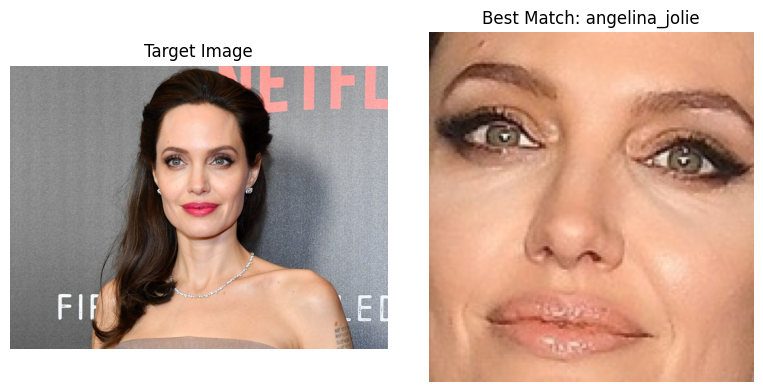


--- Testing: Kristen Stewart ---

Match found: kristen_stewart, Distance: 0.31


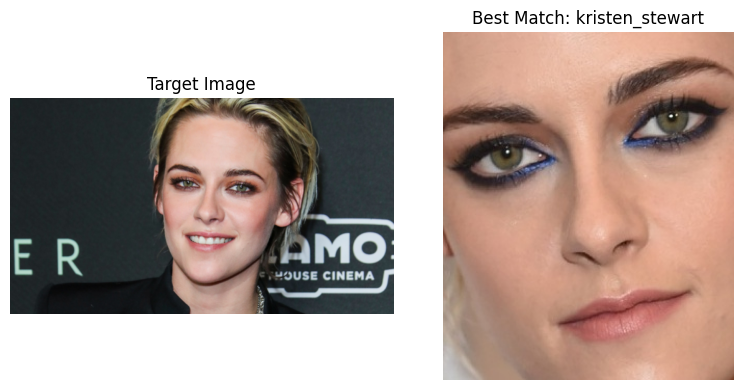


--- Testing: Hermione Granger ---

No match found. Closest match is emma_watson (Distance: 0.54).


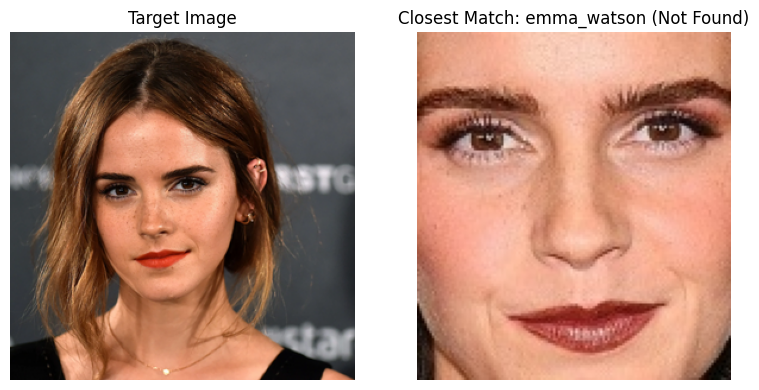

In [28]:
def main():
    """Main function to run face recognition demo."""
    # Connect to Redis
    client = get_redis_connection(REDIS_URL)

    # Ensure the RedisVL index is valid
    index = create_redis_index(client)

    # Check if Redis already contains data
    existing_data_count = int(client.dbsize())
    if existing_data_count > 0:
        print(f"Redis already contains {existing_data_count} records. Skipping data injection.")
    else:
        # Inject data into Redis from a local dataset if no data is present
        dataset_path = "kaggle_famous_people_dataset"
        inject_local_data_into_redis(dataset_path, index)
        print("Data successfully injected into Redis.")

    # Test queries
    test_cases = [
        ("https://github.com/serengil/deepface/raw/master/tests/dataset/img2.jpg", "Angelina Jolie"),
        ("https://media.hugogloss.uol.com.br/uploads/2023/10/Kristen-Stewart-617x347.png", "Kristen Stewart"),
        ("https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400", "Hermione Granger"),
    ]

    for image_url, label in test_cases:
        print(f"\n--- Testing: {label} ---")
        query_redis(image_url, index, client)


if __name__ == "__main__":
    main()

# Another use case - Authentication via Facial Recog MFA

This section demonstrates how to build a **simple authentication system** using the existing facial recognition dataset and vector similarity search (VSS) capabilities of Redis. The goal is to simulate a **multi-factor authentication (MFA)** system where users are authenticated based on:

1. **Password Validation**: A hardcoded password is checked (because this is a Lab).
2. **Claimed Identity**: The name provided by the user is compared against the database.
3. **Facial Recognition**: The user's image is matched using VSS, and the distance is validated against a configurable threshold (`SAFE_THRESHOLD`).

## How It Works
1. The user submits:
   - Their **image** (via a URL).
   - Their **name** (claimed identity).
   - A **password** (hardcoded for demo purposes).
2. The system:
   - Validates the password.
   - Converts the provided image into a vector embedding.
   - Queries Redis to find the closest match using vector similarity.
   - Checks if the name of the closest match matches the claimed identity.
   - Verifies that the similarity score (distance) is within the acceptable threshold.
3. The authentication succeeds only if **all conditions are met**.

### Here is the function that implements this simple logic


In [ ]:
def authenticate_user(image_url, claimed_name, password, index, client, threshold=SAFE_THRESHOLD):
    """
    Simulates an authentication system using vector similarity search and a hardcoded password validation.

    Args:
        image_url (str): URL of the user's image.
        claimed_name (str): Name the user is claiming to be.
        password (str): User-provided password (validated against hardcoded values).
        index (SearchIndex): Redis index to perform VSS.
        client (Redis): Redis client connection.
        threshold (float): Threshold to determine a valid match.

    Returns:
        bool: True if authentication succeeds, False otherwise.
    """
    # Hardcoded password validation (for demonstration purposes)
    valid_password = "mypassword123"
    if password != valid_password:
        print("Authentication failed: Invalid password.")
        return False

    # Generate embedding for the provided image
    user_embedding = generate_embedding(image_url)
    if user_embedding is None:
        print("Authentication failed: Could not process the image.")
        return False

    # Query Redis for the claimed name
    from redisvl.query import VectorQuery
    query = VectorQuery(
        vector=user_embedding.tolist(),
        vector_field_name="embedding",
        return_fields=["name", "vector_distance", "photo_binary"],
        num_results=1
    )
    results = index.query(query)

    if not results:
        print("Authentication failed: No matches found.")
        return False

    # Validate the best match
    best_match = results[0]
    match_name = best_match["name"]
    match_distance = float(best_match["vector_distance"])

    if match_name != claimed_name:
        print(f"Authentication failed: Claimed name '{claimed_name}' does not match the best match '{match_name}'.")
        return False

    if match_distance > threshold:
        print(f"Authentication failed: Distance {match_distance:.2f} exceeds threshold {threshold:.2f}.")
        return False

    # If all checks pass
    print(f"Authentication succeeded for user '{claimed_name}'. Distance: {match_distance:.2f}.")
    return True

### Main function - Authentication flow simulation

In [31]:
def main():
    """Main function to run face recognition demo with authentication."""
    # Connect to Redis
    client = get_redis_connection(REDIS_URL)

    # Ensure the RedisVL index is valid
    index = create_redis_index(client)

    # Check if Redis already contains data
    existing_data_count = int(client.dbsize())
    if existing_data_count > 0:
        print(f"Redis already contains {existing_data_count} records. Skipping data injection.")
    else:
        # Inject data into Redis from a local dataset if no data is present
        dataset_path = "kaggle_famous_people_dataset"
        inject_local_data_into_redis(dataset_path, index)
        print("Data successfully injected into Redis.")

    # Authentication test cases
    auth_test_cases = [
        {
            "image_url": "https://github.com/serengil/deepface/raw/master/tests/dataset/img2.jpg",
            "claimed_name": "angelina_jolie",
            "password": "mypassword123"
        },
        {
            "image_url": "https://media.glamour.com/photos/5696491d93ef4b09521035e4/master/pass/beauty-2015-08-emma-watson-perfect-skin-freckles-main.jpg",
            "claimed_name": "emma_watson",
            "password": "mypassword123"
        },
        {
            "image_url": "https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400",
            "claimed_name": "hermione_granger",  # Intentional mismatch
            "password": "mypassword123"
        },
        {
            "image_url": "https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400",
            "claimed_name": "brad_pitt",
            "password": "wrongpassword"  # Intentional wrong password
        }
    ]

    for case in auth_test_cases:
        print(f"\n🔍 Authenticating: {case['claimed_name']}...")
        success = authenticate_user(
            image_url=case["image_url"],
            claimed_name=case["claimed_name"],
            password=case["password"],
            index=index,
            client=client
        )
        if success:
            print(f"✅ Authentication succeeded for {case['claimed_name']}.")
        else:
            print(f"❌ Authentication failed for {case['claimed_name']}.")

    print("\n🎉 Authentication demo completed!")

### Running the Auth tests/simulation

In [32]:
main()

12:20:15 redisvl.index.index INFO   Index already exists, overwriting.
Redis already contains 259 records. Skipping data injection.

🔍 Authenticating: angelina_jolie...
Authentication succeeded for user 'angelina_jolie'. Distance: 0.27.
✅ Authentication succeeded for angelina_jolie.

🔍 Authenticating: emma_watson...
Authentication succeeded for user 'emma_watson'. Distance: 0.40.
✅ Authentication succeeded for emma_watson.

🔍 Authenticating: hermione_granger...
Authentication failed: Claimed name 'hermione_granger' does not match the best match 'emma_watson'.
❌ Authentication failed for hermione_granger.

🔍 Authenticating: brad_pitt...
Authentication failed: Invalid password.
❌ Authentication failed for brad_pitt.

🎉 Authentication demo completed!
